In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')
import warnings
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification

from CustomModel import funnel_viz, MultiLevelLogisticRegression

# Parameters of the setup

In [3]:
pop_size = 1000
steps = 3
conversion_rates = [0.7, 0.3, 0.2]
assert steps >= 1
assert steps == len(conversion_rates)

<AxesSubplot:>

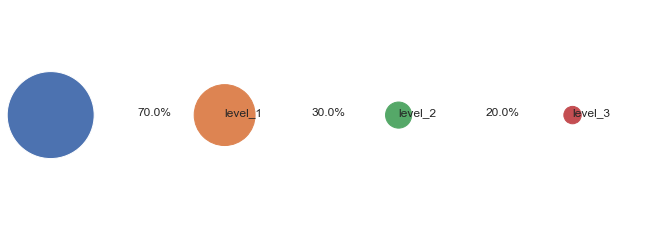

In [4]:
funnel_viz(steps, conversion_rates)

# Synthetic data generation

In [7]:
np.random.seed(42)

df = pd.DataFrame({'cid': list(range(pop_size))})\
# assigning which customer is present in which level of funnel
df['level_1'] = (np.random.random(pop_size) <= conversion_rates[0]).astype(int)
for i, rate in enumerate(conversion_rates[1:], 2):
    df[f"level_{i}"] = 0
    df.loc[df[f"level_{i-1}"] == 1, f"level_{i}"] = (np.random.random(df[f"level_{i-1}"].sum()) <= rate).astype(int)

# ensure that if a certain level is 0 then all levels after it must be 0 as well
# basically if this is true then the values in all rows will be strictly non-increasing
target_cols = [f"level_{i}" for i in range(1, steps+1)]
assert (df[target_cols].diff(axis=1).iloc[:,1:] <= 0).all(axis=None)

# Create random features for modeling
# random positive semidefinite matrix (for covariance)
matrixSize = 2
A = np.random.rand(matrixSize, matrixSize)
B = np.dot(A, A.transpose())

μ = [0.3, 0.4]
d = np.random.multivariate_normal(μ, B, pop_size)
d = pd.DataFrame(d)
feature_cols = ['f1','f2']
d.columns = feature_cols

df = pd.concat([df, d], axis=1)
df['target'] = df[target_cols].sum(axis=1)
df['target'] = df['target'].map(dict(zip(range(steps+1), ['Everyone']+target_cols))).astype('category')
df['target'] = df['target'].cat.reorder_categories(['Everyone']+target_cols, ordered=True)
df

,cid,level_1,level_2,level_3,f1,f2,target
0,0,1,1,0,0.335009,0.145163,level_2
1,1,0,0,0,-0.968090,-1.543815,Everyone
2,2,0,0,0,0.342296,0.209748,Everyone
3,3,1,0,0,-1.131018,-0.981796,level_1
4,4,1,0,0,-0.834800,-0.893035,level_1
...,...,...,...,...,...,...,...
995,995,1,0,0,0.493598,0.897979,level_1
996,996,0,0,0,1.500557,1.515631,Everyone
997,997,1,1,0,0.471528,1.042322,level_2
998,998,0,0,0,0.356592,1.066494,Everyone


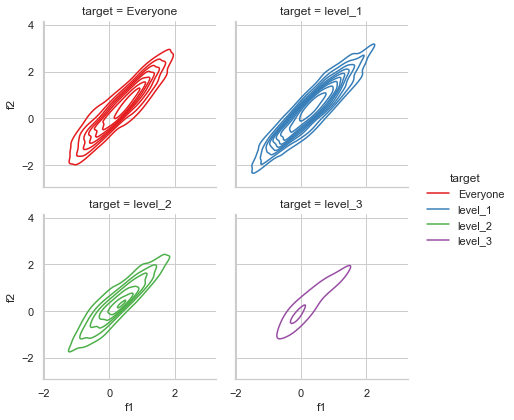

In [8]:
# check if features are sensible
# conceptually each successive conversion step should be done by people who are a subset (in feature space) of the previous step
sns.displot(data=df, kind='kde', 
            x='f1', y='f2', 
            hue='target', col='target', col_wrap=2, 
            palette='Set1', height=3)

# Building custom classifier

In [11]:
clf = MultiLevelLogisticRegression(steps, LogisticRegression)

In [12]:
clf.fit(df[feature_cols], df[target_cols])

Fitting level_1 model with 1000 datapoints and 71.2% class mean.
Fitting level_2 model with 712 datapoints and 29.4% class mean.
Fitting level_3 model with 209 datapoints and 21.1% class mean.


MultiLevelLogisticRegression(clf_cls=<class 'sklearn.linear_model._logistic.LogisticRegression'>,
                             clf_kws={}, steps=3)

In [14]:
clf.predict(df[feature_cols])

,pred_level_1,pred_level_2,pred_level_3
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0
...,...,...,...
995,1,0,0
996,1,0,0
997,1,0,0
998,1,0,0


In [15]:
probs = clf.predict_proba(df[feature_cols])
probs

,pred_prob_level_1,pred_prob_level_2,pred_prob_level_3
0,0.717451,0.283026,0.202890
1,0.763261,0.310712,0.208902
2,0.716078,0.284603,0.204130
3,0.754800,0.340515,0.228493
4,0.750102,0.323732,0.219730
...,...,...,...
995,0.700339,0.297071,0.215031
996,0.675260,0.255437,0.194476
997,0.697608,0.303144,0.219325
998,0.698454,0.311316,0.224140


# Analyzing results

In [16]:
df_preds = pd.concat([df, probs], axis=1)
df_preds

,cid,level_1,level_2,level_3,f1,f2,target,pred_prob_level_1,pred_prob_level_2,pred_prob_level_3
0,0,1,1,0,0.335009,0.145163,level_2,0.717451,0.283026,0.202890
1,1,0,0,0,-0.968090,-1.543815,Everyone,0.763261,0.310712,0.208902
2,2,0,0,0,0.342296,0.209748,Everyone,0.716078,0.284603,0.204130
3,3,1,0,0,-1.131018,-0.981796,level_1,0.754800,0.340515,0.228493
4,4,1,0,0,-0.834800,-0.893035,level_1,0.750102,0.323732,0.219730
...,...,...,...,...,...,...,...,...,...,...
995,995,1,0,0,0.493598,0.897979,level_1,0.700339,0.297071,0.215031
996,996,0,0,0,1.500557,1.515631,Everyone,0.675260,0.255437,0.194476
997,997,1,1,0,0.471528,1.042322,level_2,0.697608,0.303144,0.219325
998,998,0,0,0,0.356592,1.066494,Everyone,0.698454,0.311316,0.224140


In [17]:
a = pd.melt(df_preds, id_vars=['cid','f1','f2','target'], value_vars=target_cols, var_name='level', value_name='final_level')
b = pd.melt(df_preds, id_vars=['cid','f1','f2','target'], value_vars=[f"pred_prob_{l}" for l in target_cols], var_name='level', value_name='pred_level')
m = pd.merge(a, b, how='outer', on=['cid','f1','f2','target'])
m

,cid,f1,f2,target,level_x,final_level,level_y,pred_level
0,0,0.335009,0.145163,level_2,level_1,1,pred_prob_level_1,0.717451
1,0,0.335009,0.145163,level_2,level_1,1,pred_prob_level_2,0.283026
2,0,0.335009,0.145163,level_2,level_1,1,pred_prob_level_3,0.202890
3,0,0.335009,0.145163,level_2,level_2,1,pred_prob_level_1,0.717451
4,0,0.335009,0.145163,level_2,level_2,1,pred_prob_level_2,0.283026
...,...,...,...,...,...,...,...,...
8995,999,-0.463632,-0.601953,level_2,level_2,1,pred_prob_level_2,0.309221
8996,999,-0.463632,-0.601953,level_2,level_2,1,pred_prob_level_3,0.213363
8997,999,-0.463632,-0.601953,level_2,level_3,0,pred_prob_level_1,0.740746
8998,999,-0.463632,-0.601953,level_2,level_3,0,pred_prob_level_2,0.309221


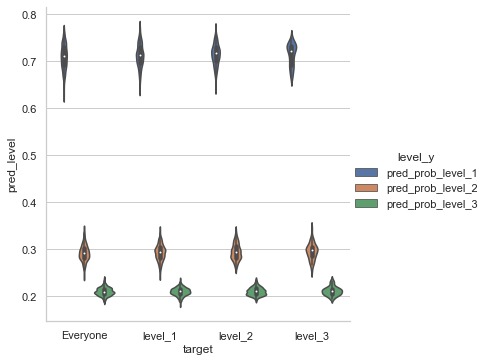

In [18]:
sns.catplot(data=m, kind='violin',
            x='target', y='pred_level', hue='level_y')